In [1]:
import numpy as np
import cv2
import json
from paz.core import ops
from mrcnn import visualize, utils
import tensorflow as tf
import matplotlib.pyplot as plt
from pose_estimation.solver import PnPSolver
from pose_estimation.pose_evaluation import PoseError
from pose_estimation.pose import compute_poses

In [2]:
results_path = '/home/incendio/Desktop/inference_results/for_10k_data/bce/binary_masks/results_2.json'
ground_truth_path = '/home/incendio/Desktop/inference_results/for_10k_data/bce/binary_masks/ground_truth_2.json'
with open(results_path, 'r') as f:
    results = json.load(f)
    
with open(ground_truth_path, 'r') as f:
    ground_truth = json.load(f)

(320, 320, 7)
[ 7 16  1 21  2 20  3]


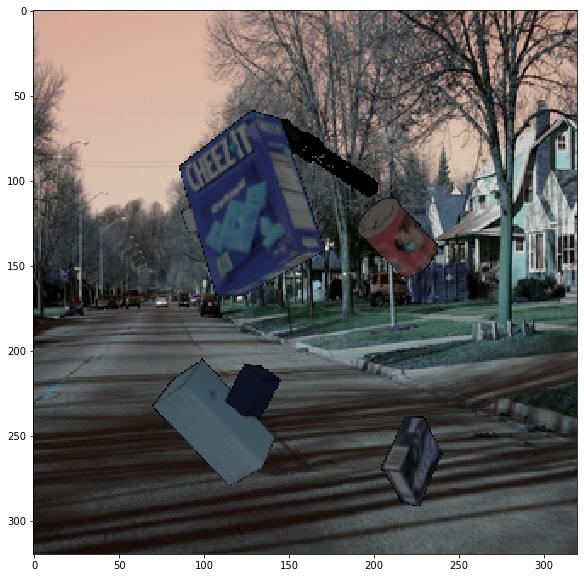

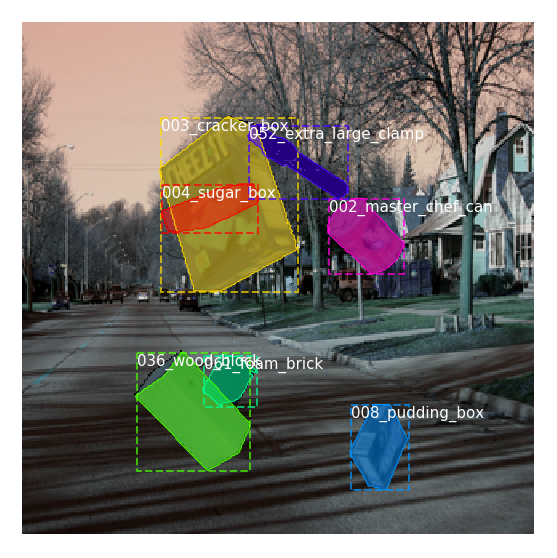

In [3]:
class_names = ['background', '002_master_chef_can', '003_cracker_box',
               '004_sugar_box', '005_tomato_soup_can', '006_mustard_bottle',
               '007_tuna_fish_can', '008_pudding_box', '009_gelatin_box',
               '010_potted_meat_can', '011_banana', '019_pitcher_base',
               '021_bleach_cleanser', '024_bowl',
               '025_mug', '035_power_drill',
               '036_wood_block', '037_scissors',
               '040_large_marker', '051_large_clamp',
               '052_extra_large_clamp', '061_foam_brick']

img_path = '/home/incendio/Desktop/inference_results/for_10k_data/bce/binary_masks/image_2.png'

def prepare_results(path, data, is_gt=True):
    img = cv2.imread(path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    box = np.array(data['rois'])
    class_id = np.array(data['class_ids'])
    masks = np.array(data['gt_masks'])
    print(masks.shape)
    return image, box, class_id, masks

image, gt_box, gt_class_id, gt_masks = prepare_results(img_path, ground_truth)
print(gt_class_id)
fig = plt.figure(figsize=(10, 10))
plt.imshow(image)
visualize.display_instances(image, gt_box, gt_masks, gt_class_id, class_names, show_bbox=True, figsize=(10, 10))

[ 2  1 16 21 14 20]


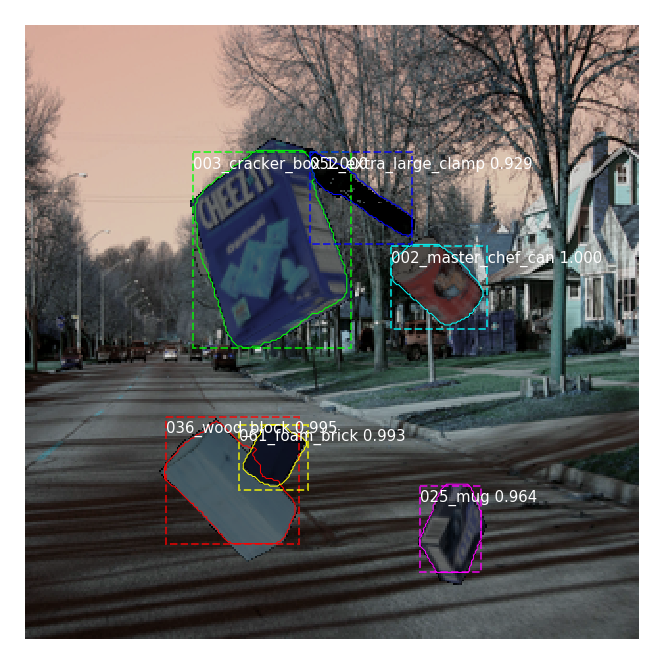

In [4]:
r = results
rois = np.array(r['rois'])
class_ids = np.array(r['class_ids'])
N = len(class_ids)

r_masks = np.array(r['masks'])
# g_masks = np.array(r['g_masks'])
# b_masks = np.array(r['b_masks'])

r_masks = (r_masks * 255).astype(np.uint8)
# g_masks = (g_masks * 255).astype(np.uint8)
# b_masks = (b_masks * 255).astype(np.uint8)
# masks = []
# for i in range(r_masks.shape[-1]):
#     masks.append(np.stack([r_masks[:, :, i], g_masks[:, :, i], b_masks[:, :, i]], axis=2))
# masks = np.stack(masks)
print(class_ids)
visualize.display_instances(image, rois, r_masks, class_ids, class_names, results['scores'], show_bbox=True, show_mask=False, figsize=(12, 12))

[1.         1.         1.         1.         1.         0.83333333
 0.83333333 0.        ]


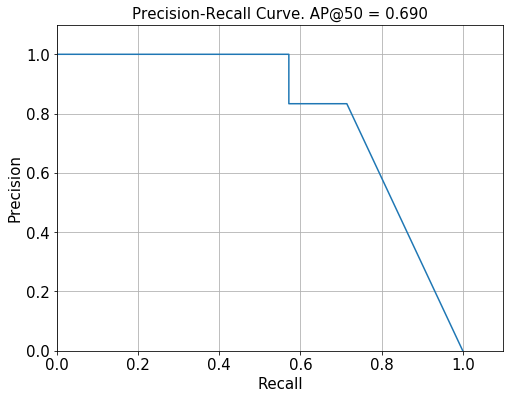

In [15]:
def plot_precision_recall(AP, precisions, recalls):
    # Plot the Precision-Recall curve
    _, ax = plt.subplots(1, figsize=(8, 6))
    ax.set_title("Precision-Recall Curve. AP@50 = {:.3f}".format(AP), fontsize=15)
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1.1)
    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid()
    _ = ax.plot(recalls, precisions)

# print(class_ids)
# cs = np.array([2, 1, 16, 21, 15, 20])
AP, precisions, recalls, overlaps = utils.compute_ap_binary(gt_box, gt_class_id, gt_masks, 
                                          rois, class_ids, np.array(r['scores']), np.array(r['masks']))
print(precisions)
plot_precision_recall(AP, precisions, recalls)
# visualize.plot_overlaps(gt_class_id, class_ids, results['scores'], overlaps, class_names)

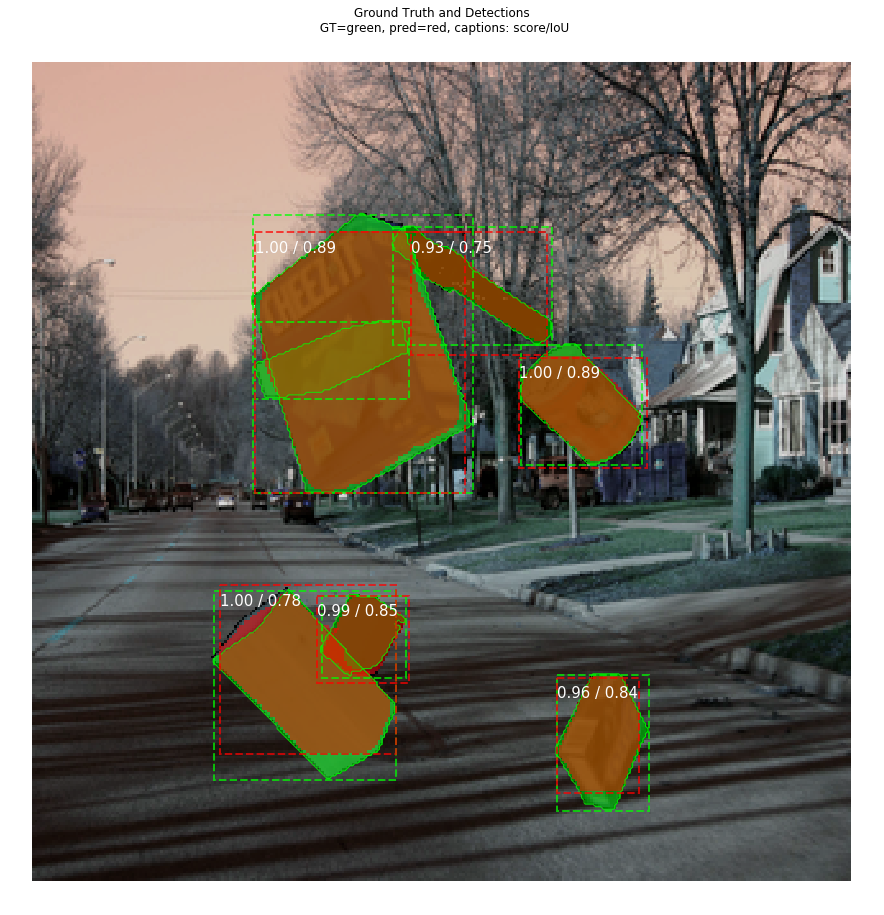

In [6]:
visualize.display_differences(image, gt_box, gt_class_id, gt_masks, rois, class_ids, np.array(r['scores']),
                             np.array(r['masks']), class_names)

In [7]:
recall_path = '/home/incendio/Desktop/inference_results/for_10k_data/bce/binary_masks/recall.json'
precision_path = '/home/incendio/Desktop/inference_results/for_10k_data/bce/binary_masks/precisions.json'

In [8]:
with open(recall_path, 'r') as f:
    recalls = json.load(f)
with open(precision_path, 'r') as f:
    precisions = json.load(f)

print(recalls[0])
print(recalls[2])

[0.0, 0.1428571492433548, 0.2857142984867096, 0.4285714328289032, 0.5714285969734192, 0.7142857313156128, 0.8571428656578064, 1.0]
[0.0, 0.1428571492433548, 0.2857142984867096, 0.4285714328289032, 0.5714285969734192, 0.5714285969734192, 0.7142857313156128, 0.7142857313156128, 1.0]


ValueError: setting an array element with a sequence.

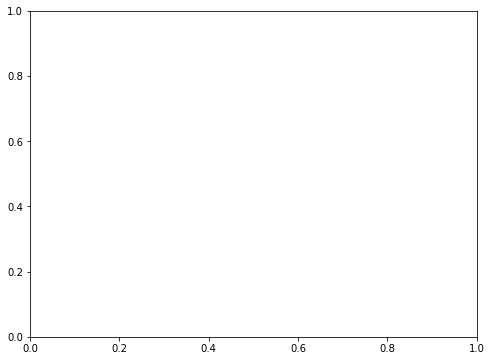

In [9]:
fig = plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions)
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.xlim(0, 1)
plt.ylim(0, 1.01)
plt.grid()
plt.show()